# Finetuning Torchvision Models -  1.2.0
---

* [Link](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)
* [Transfer Learning](https://cs231n.github.io/transfer-learning/)
* [Transfer Learning 2](https://ruder.io/transfer-learning/)
* [Hymenoptera Dataset Download](https://download.pytorch.org/tutorial/hymenoptera_data.zip)
* [How to optimize inception model with auxiliary classifiers](https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958)
* [Incpetion v3 Advanced - Google](https://cloud.google.com/tpu/docs/inception-v3-advanced)

As each model architecture is different, there is no boilerplate fintuning code that will work in all scenarios.

Two types of transfer learning: finetuning and feature extraction.

In **finetuning**, we start with a pretrained model and update all of the model's parameters for our new task, in essence retraining the whole model.

In **feature extraction**, we start with a pretrained model and only update the final layer weights from which we derive predictions. It is called feature extraction because we use the pretrained CNN as a fixed feature-extractor, and only change the output layer.

In general both transfer learning methods follow the same few steps:
* Initialize the pretrained model
* Reshape the final layer(s) to have the same number of outputs as the number of classes in the new dataset
* Define for the optimization algorithm which parameters we want to update during training
* Run the training step

## <u>Papers</u>
* [Deep Residual Learning for Image Recognition - Resnet](https://arxiv.org/abs/1512.03385)
* [ImageNet Classification with Deep Convolutional Neural Network - Alexnet](https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)
* [Very Deep Convolutional Networks fro Large-Scale Image Recognition - VGG](https://arxiv.org/pdf/1409.1556.pdf)
* [Squeezenet: AlexNet-level accuracy with 50x fewer parameters and <0.5MB model size](https://arxiv.org/abs/1602.07360)
* [Densely Connected Convolutional Networks](https://arxiv.org/abs/1608.06993)
* [Rethinking the Inception Architecture for Computer Vision](https://arxiv.org/pdf/1512.00567v1.pdf)

In [2]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)

PyTorch Version:  1.13.1+cu117
Torchvision Version:  0.14.1+cu117


In [3]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Inputs
---

In [14]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder stucture
data_dir = "../data/hymenoptera_data"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "densenet"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

# Helper Functions
---

## <u>Model Training and Validation Code</u>

In [5]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()   # Set model to training mode
            else:
                model.eval()    # Set model to evaluation mode
            
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                #track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    # mode we calculate the loss by summing the final output and the auxiliary output
                    # but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
        
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history


## <u>Set Model Parameters' .requires_grad attribute</u>

In [6]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

# Initialize and Reshape the Networks
---

In [15]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of
    # these variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    
    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224
    
    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxiliary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 299
    
    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just initiated
print(model_ft)
        

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

/home/blast/Softwares/conda/envs/py-38/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Load Data
---

In [8]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")
# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                    data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x],
                    batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

#  Detect if we have a GPU available (Done Above)

Initializing Datasets and Dataloaders...


#  Create the Optimizer
---


In [18]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#   finetuning we will be updating all parameters. However, if we are
#   doing feature extract method, we will only update the parameters
#   that we have just initialized, i.e. the parameters with requires_grad
#   is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)
else:
    for name, param in model_ft.named_parameters():
        if param.requiers_grad == True:
            print("\t", name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.weight
	 classifier.bias


# Run Training and Validation Step
---

In [19]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, 
                    optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/14
----------
train Loss: 0.2632 Acc: 0.9098
val Loss: 0.2296 Acc: 0.9281

Epoch 1/14
----------
train Loss: 0.2322 Acc: 0.8811
val Loss: 0.2129 Acc: 0.9346

Epoch 2/14
----------
train Loss: 0.3244 Acc: 0.8607
val Loss: 0.2270 Acc: 0.9346

Epoch 3/14
----------
train Loss: 0.1876 Acc: 0.9221
val Loss: 0.2172 Acc: 0.9281

Epoch 4/14
----------
train Loss: 0.2588 Acc: 0.8689
val Loss: 0.1895 Acc: 0.9150

Epoch 5/14
----------
train Loss: 0.2108 Acc: 0.9262
val Loss: 0.2030 Acc: 0.9216

Epoch 6/14
----------
train Loss: 0.2264 Acc: 0.8934
val Loss: 0.2110 Acc: 0.9281

Epoch 7/14
----------
train Loss: 0.2397 Acc: 0.8852
val Loss: 0.1885 Acc: 0.9085

Epoch 8/14
----------
train Loss: 0.2726 Acc: 0.8770
val Loss: 0.2682 Acc: 0.9085

Epoch 9/14
----------
train Loss: 0.1804 Acc: 0.9221
val Loss: 0.1806 Acc: 0.9281

Epoch 10/14
----------
train Loss: 0.1904 Acc: 0.9139
val Loss: 0.1893 Acc: 0.9216

Epoch 11/14
----------
train Loss: 0.1822 Acc: 0.9057
val Loss: 0.1896 Acc: 0.9216

Ep

# Comparison with Model Trained from Scratch
---

Epoch 0/14
----------
train Loss: 0.6856 Acc: 0.5574
val Loss: 0.6483 Acc: 0.6601

Epoch 1/14
----------
train Loss: 0.6601 Acc: 0.5943
val Loss: 0.6469 Acc: 0.7059

Epoch 2/14
----------
train Loss: 0.6637 Acc: 0.6066
val Loss: 0.6564 Acc: 0.6405

Epoch 3/14
----------
train Loss: 0.5877 Acc: 0.6926
val Loss: 0.7009 Acc: 0.6209

Epoch 4/14
----------
train Loss: 0.5886 Acc: 0.6926
val Loss: 0.6576 Acc: 0.6601

Epoch 5/14
----------
train Loss: 0.6291 Acc: 0.6475
val Loss: 0.5888 Acc: 0.6993

Epoch 6/14
----------
train Loss: 0.5900 Acc: 0.6721
val Loss: 0.6195 Acc: 0.6340

Epoch 7/14
----------
train Loss: 0.6262 Acc: 0.6680
val Loss: 0.5593 Acc: 0.6928

Epoch 8/14
----------
train Loss: 0.5773 Acc: 0.6803
val Loss: 0.8185 Acc: 0.5948

Epoch 9/14
----------
train Loss: 0.5575 Acc: 0.7131
val Loss: 0.6438 Acc: 0.6993

Epoch 10/14
----------
train Loss: 0.5408 Acc: 0.6967
val Loss: 0.6348 Acc: 0.7255

Epoch 11/14
----------
train Loss: 0.5595 Acc: 0.6967
val Loss: 0.6910 Acc: 0.6667

Ep

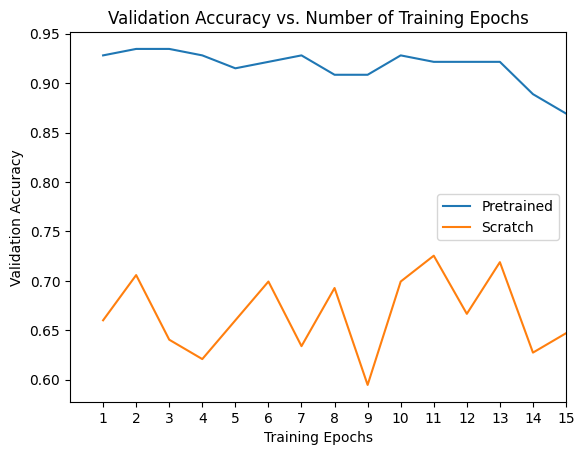

In [20]:
# Initialize the non-pretrained version of the emodel used for this run
scratch_model, _ = initialize_model(model_name, num_classes, 
                                    feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_, scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, 
                                scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

# Plot the training curves of validation accuracy vs. number
#   of training epochs for the transfer learning method and
#   the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1, num_epochs + 1), ohist, label="Pretrained")
plt.plot(range(1, num_epochs + 1), shist, label="Scratch")
plt.xlim((0,1.))
plt.xticks(np.arange(1, num_epochs + 1, 1.0))
plt.legend()
plt.show()